# Laboratorium

### Konfiguracja

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [4]:
%matplotlib notebook
import math
import random
from typing import Optional

### Tolerancje przyjmujemy na 10^-10

In [5]:
TOLERANCE = 1e-10
TOLERANCE_DECIMALS = 10

### Funkcje pomocnicze i funkcja sprawdzająca przecięcie się linii

In [6]:
def det_3x3(a):
    return a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])\
           -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])\
           +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2])
def det(a,b,c):
    matrix = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return det_3x3(matrix)
def orient(a, b, c):
    d = det(a, b, c)
    if d > TOLERANCE:
        return 1
    elif d < - TOLERANCE:
        return -1
    else:
        return 0

In [7]:
def on_segment(a,b,c):
    return min(a[0], b[0]) <= c[0] <= max(a[0], b[0]) and min(a[1], b[1]) <= c[1] <= max(a[1], b[1])
def intersect(l1, l2):
    p1 = l1[0]
    p2 = l1[1]
    p3 = l2[0]
    p4 = l2[1]
    o1 = orient(p1, p2, p3)
    o2 = orient(p1, p2, p4)
    o3 = orient(p3, p4, p1)
    o4 = orient(p3, p4, p2)
    
    if o1 != o2 and o3 != o4:
        return True
    if o1 == 0 and on_segment(p1,p2,p3):
        return True
    if o2 == 0 and on_segment(p1,p2,p4):
        return True
    if o3 == 0 and on_segment(p3,p4,p1):
        return True
    return o4 == 0 and on_segment(p3,p4,p2)

### Losowe odcinki

In [8]:
def get_x(lowerLeft, upperRight):
    return round(random.uniform(lowerLeft[0], upperRight[0]), TOLERANCE_DECIMALS)
def get_y(lowerLeft, upperRight):
    return round(random.uniform(lowerLeft[1], upperRight[1]), TOLERANCE_DECIMALS)

#n - number of lines to create
#lowerLeft - tuple representing lower left corner of our range rectanglge
#upperRight - tuple representing upper right corner of our range rectanglge
def random_lines(n, lowerLeft, upperRight):
    Xpoints = set()
    lines = []

    while len(lines) < n:
        x1, y1 = get_x(lowerLeft, upperRight), get_y(lowerLeft, upperRight)
        x2, y2 = get_x(lowerLeft, upperRight), get_y(lowerLeft, upperRight)
        l = [(x1,y1), (x2,y2)]
        if x1 > x2:
            l = [(x2,y2), (x1,y1)] 
        
        if x1 == x2 or len({x1,x2} & Xpoints):
            continue
        
        canAdd = True
        for line in lines:
            if intersect(line, l):
                canAdd = False
                break
        if not canAdd:
            continue
            
        lines.append(l)
        Xpoints.update([x1,x2])
       
    return lines

### przykład działania

<IPython.core.display.Javascript object>


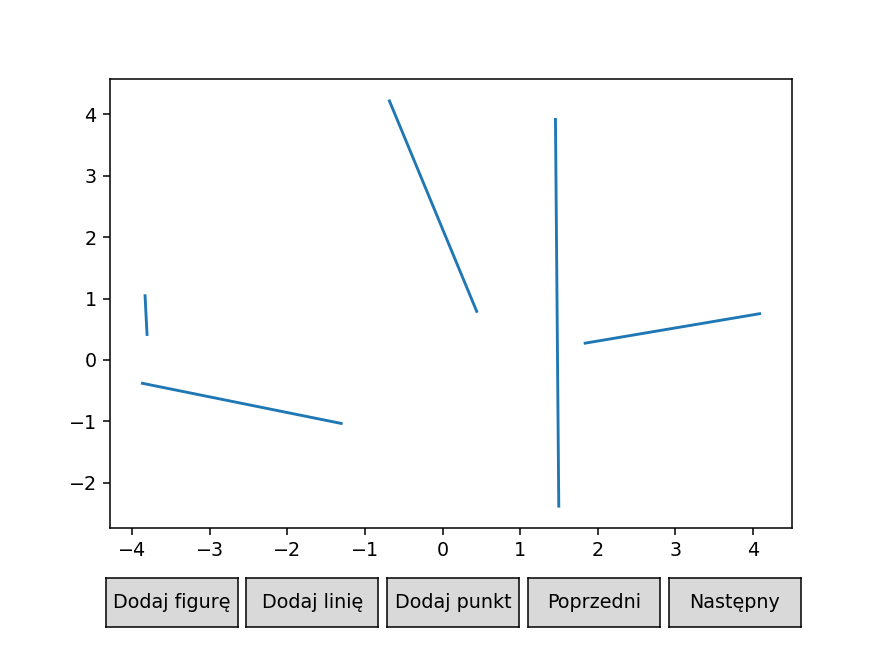

In [9]:
l = random_lines(5, (-4, -3), (5, 7))
plot = Plot([Scene(lines=[LinesCollection(l)])])
plot.draw()

### Zapis odcinków do pliku

In [10]:
def save_lines_to_file(lines, name):
    lines_ = [] 
    for line in lines:
        if line[0][0] < line[1][0]:
            lines_.append(line)
        else:
            lines_.append([line[1], line[0]])
    
    with open(name, 'w') as file:
        file.write(js.dumps(lines_))

In [11]:
def save_plot_to_file(plot, name):
    lines = plot_to_lines(plot)
    save_lines_to_file(lines, name)

### Funkcja zwracająca linie z danego plotu

In [12]:
def plot_to_lines(plot):
    lines = [line for line in (lines.lines for lines in plot.get_added_lines())][0] 
    lines_ = []
    for line in lines:
        if line[0][0] < line[1][0]:
            lines_.append(line)
        else:
            lines_.append([line[1], line[0]])
    return lines_

### Czytanie odcinków z pliku

In [13]:
def read_lines_from_file(name):
    with open(name, 'r') as file:
        lines = js.loads(file.read())
    return lines

### WŁASNE RYSOWANIE

<IPython.core.display.Javascript object>


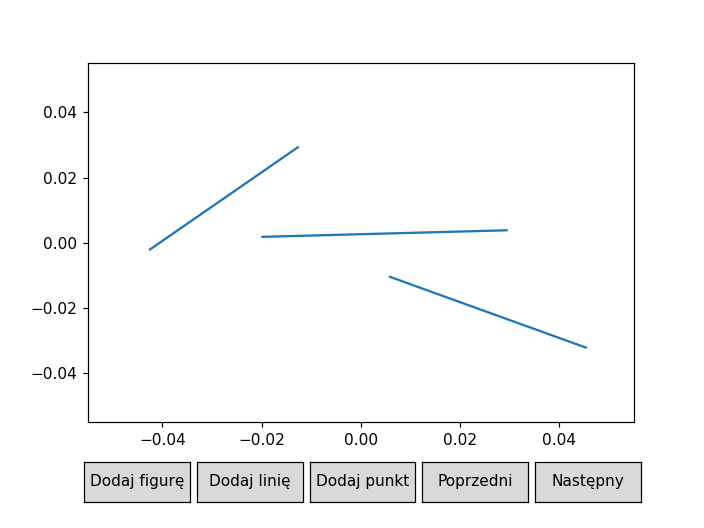

In [20]:
plot1 = Plot()
plot1.draw()

In [21]:
l1 = plot_to_lines(plot1)

### Struktury Danych

In [14]:
class Point:
    def __init__(self,
                 x: float,
                 y: float) -> None:
        self.x = x
        self.y = y

In [15]:
class Line:
    def __init__(self,
                 p: Point,
                 q: Point) -> None:
        if q.x < p.x:
            p, q = q, p
        self.left = p
        self.right = q

        self.a = (self.left.y - self.right.y) / \
                 (self.left.x - self.right.x)
        self.b = self.left.y - (self.a * self.left.x)

    def is_line_below_point(self, point: Point) -> bool:
        return point.y > self.value_at_x(point.x)

    def value_at_x(self, x: float) -> Optional[float]:
        if self.left.x <= x <= self.right.x:
            return (self.a * x) + self.b
        return None

In [16]:
class Trapeze:
    def __init__(self,
                 top: Optional[Line],
                 bottom: Optional[Line],
                 left: Optional[Point],
                 right: Optional[Point]) -> None:
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right

        self.upper_left = None
        self.lower_left = None
        self.upper_right = None
        self.lower_right = None

        self.node = None

### Węzły: wierzchołków - XNode, odcinków - YNode, ścian - LeafNode 

In [17]:
class XNode:
    def __init__(self,
                 point: Point,
                 left=None,
                 right=None) -> None:
        self.point = point
        self.left = None
        self.right = None
        self.set_left(left)
        self.set_right(right)

    def set_left(self, node) -> None:
        self.left = node
        if isinstance(node, LeafNode) and self not in node.parents:
            node.parents.append(self)

    def set_right(self, node) -> None:
        self.right = node
        if isinstance(node, LeafNode) and self not in node.parents:
            node.parents.append(self)

    def is_point_on_left_side(self, q: Point) -> bool:
        return q.x < self.point.x

In [18]:
class YNode:
    def __init__(self,
                 line: Line,
                 above=None,
                 below=None) -> None:
        self.line = line
        self.above = None
        self.below = None
        self.set_above(above)
        self.set_below(below)

    def set_above(self, node):
        self.above = node
        if isinstance(node, LeafNode) and self not in node.parents:
            node.parents.append(self)

    def set_below(self, node):
        self.below = node
        if node is None:
            return
        if isinstance(node, LeafNode) and self not in node.parents:
            node.parents.append(self)

    def is_point_above(self, q: Point) -> bool:
        return q.y > self.line.value_at_x(q.x)

In [19]:
class LeafNode:
    def __init__(self, trapeze: Trapeze) -> None:
        self.parents = []
        self.trapeze = trapeze
        self.trapeze.node = self

    def replace(self, search_graph, node) -> None:
        if not self.parents:
            search_graph.set_root(node)
            return
        for parent in self.parents:
            if isinstance(parent, XNode):
                if parent.left == self:
                    parent.set_left(node)
                else:
                    parent.set_right(node)
            else:
                if parent.above == self:
                    parent.set_above(node)
                else:
                    parent.set_below(node)

### graf wyszukiwania

In [21]:
class SearchGraph:
    def __init__(self, root) -> None:
        self.root = root

    def set_root(self, root):
        self.root = root

    def find(self, point: Point, node=None) -> Trapeze:
        if node is None:
            node = self.root

        if isinstance(node, LeafNode):
            return node.trapeze

        if isinstance(node, XNode):
            if node.is_point_on_left_side(point):
                return self.find(point, node.left)
            return self.find(point, node.right)
        if isinstance(node, YNode):
            if node.is_point_above(point):
                return self.find(point, node.above)
            return self.find(point, node.below)
    
    def is_point_in_search_graph(self, point: Point, node=None) -> bool:
        if node is None:
            node = self.root

        if isinstance(node, LeafNode):
            return False

        if isinstance(node, XNode):
            if node.point == point:
                return True
            if node.is_point_on_left_side(point):
                return self.find(point, node.left)
            return self.find(point, node.right)
        if isinstance(node, YNode):
            if node.is_point_above(point):
                return self.find(point, node.above)
            return self.find(point, node.below)

### funkcje pomocnicze

In [22]:
def permute(lines: list[list[tuple]]) -> list[list[tuple]]:
    return random.sample(lines, len(lines))

In [23]:
def get_line(line: list[tuple]) -> Line:
    point_a = Point(line[0][0], line[0][1])
    point_b = Point(line[1][0], line[1][1])
    return Line(point_a, point_b)

### funkcje zmieniające, aktualizujące sąsiadów 

In [24]:
def update_left_neighbours(old_trapeze: Trapeze,
                           new_trapeze: Trapeze) -> None:
    def update(trapeze: Trapeze) -> None:
        if trapeze:
            if trapeze.upper_right == old_trapeze:
                trapeze.upper_right = new_trapeze
            if trapeze.lower_right == old_trapeze:
                trapeze.lower_right = new_trapeze

    update(old_trapeze.upper_left)
    update(old_trapeze.lower_left)

In [25]:
def update_right_neighbours(old_trapeze: Trapeze,
                            new_trapeze: Trapeze) -> None:
    def update(trapeze: Trapeze) -> None:
        if trapeze:
            if trapeze.upper_left == old_trapeze:
                trapeze.upper_left = new_trapeze
            if trapeze.lower_left == old_trapeze:
                trapeze.lower_left = new_trapeze

    update(old_trapeze.upper_right)
    update(old_trapeze.lower_right)

In [26]:
def set_neighbours(trapeze: Trapeze,
                   upper_right: Optional[Trapeze] = None,
                   lower_right: Optional[Trapeze] = None,
                   upper_left: Optional[Trapeze] = None,
                   lower_left: Optional[Trapeze] = None) -> None:
    trapeze.upper_right = upper_right
    trapeze.lower_right = lower_right
    trapeze.upper_left = upper_left
    trapeze.lower_left = lower_left

In [27]:
def update_neighbours(trapeze: Trapeze,
                      upper_right: Optional[Trapeze] = 'empty',
                      lower_right: Optional[Trapeze] = 'empty',
                      upper_left: Optional[Trapeze] = 'empty',
                      lower_left: Optional[Trapeze] = 'empty') -> None:
    if upper_right != 'empty':
        trapeze.upper_right = upper_right
    if lower_right != 'empty':
        trapeze.lower_right = lower_right
    if upper_left != 'empty':
        trapeze.upper_left = upper_left
    if lower_left != 'empty':
        trapeze.lower_left = lower_left

### funkcja znajdująca strefę (wszystkie trapezy przecięte przez odcinek)

In [28]:
def find_zone(start_trapeze: Trapeze, line: Line) -> list[Trapeze]:
    q = line.right
    zone = [start_trapeze]
    current = start_trapeze

    while current.right.x < q.x:
        if current.right.y > line.value_at_x(current.right.x):
            current = current.lower_right
        else:
            current = current.upper_right
        zone.append(current)
    return zone

### Odcinek znajduje się w całości w jednym trapezie

In [29]:
def line_in_single_trapeze(search_graph: SearchGraph,
                           trapeze: Trapeze,
                           line: Line) -> list[Trapeze]:
    left_trapeze = Trapeze(trapeze.top, trapeze.bottom, trapeze.left, line.left)
    upper_trapeze = Trapeze(trapeze.top, line, line.left, line.right)
    lower_trapeze = Trapeze(line, trapeze.bottom, line.left, line.right)
    right_trapeze = Trapeze(trapeze.top, trapeze.bottom, line.right, trapeze.right)

    set_neighbours(
        left_trapeze,
        upper_right=upper_trapeze,
        upper_left=trapeze.upper_left,
        lower_right=lower_trapeze,
        lower_left=trapeze.lower_left)

    set_neighbours(
        upper_trapeze,
        upper_right=right_trapeze,
        upper_left=left_trapeze,
        lower_right=right_trapeze,
        lower_left=left_trapeze)

    set_neighbours(
        lower_trapeze,
        upper_right=right_trapeze,
        upper_left=left_trapeze,
        lower_right=right_trapeze,
        lower_left=left_trapeze)

    set_neighbours(
        right_trapeze,
        upper_right=trapeze.upper_right,
        upper_left=upper_trapeze,
        lower_right=trapeze.lower_right,
        lower_left=lower_trapeze)

    update_left_neighbours(trapeze, left_trapeze)
    update_right_neighbours(trapeze, right_trapeze)

    left_trapeze_node = LeafNode(left_trapeze)
    upper_trapeze_node = LeafNode(upper_trapeze)
    lower_trapeze_node = LeafNode(lower_trapeze)
    right_trapeze_node = LeafNode(right_trapeze)

    sNode = YNode(line, upper_trapeze_node, lower_trapeze_node)
    qNode = XNode(line.right, sNode, right_trapeze_node)
    pNode = XNode(line.left, left_trapeze_node, qNode)
    trapeze.node.replace(search_graph, pNode)

    return [left_trapeze, upper_trapeze, lower_trapeze, right_trapeze]

### Odcinek przecina wiele trapezów

In [30]:
def line_in_multiple_trapezes(search_graph: SearchGraph,
                              trapezes: list[Trapeze],
                              line: Line) -> list[Trapeze]:
    upper_trapeze = None
    lower_trapeze = None
    merge_upper = False

    added_trapezes = []

    for i in range(len(trapezes)):
        trapeze = trapezes[i]

        if i == 0:

            left_trapeze = Trapeze(
                trapeze.top,
                trapeze.bottom,
                trapeze.left,
                line.left)
            if line.is_line_below_point(trapeze.right):
                upper_trapeze = Trapeze(
                    trapeze.top,
                    line,
                    line.left,
                    trapeze.right)
                lower_trapeze = Trapeze(
                    line,
                    trapeze.bottom,
                    line.left,
                    None)
                merge_upper = False
            else:
                upper_trapeze = Trapeze(
                    trapeze.top,
                    line,
                    line.left,
                    None)
                lower_trapeze = Trapeze(
                    line,
                    trapeze.bottom,
                    line.left,
                    trapeze.right)
                merge_upper = True

            set_neighbours(left_trapeze,
                           upper_right=upper_trapeze,
                           upper_left=trapeze.upper_left,
                           lower_right=lower_trapeze,
                           lower_left=trapeze.lower_left)
            update_left_neighbours(trapeze, left_trapeze)

            update_neighbours(upper_trapeze,
                              upper_left=left_trapeze,
                              lower_left=left_trapeze)
            update_neighbours(lower_trapeze,
                              upper_left=left_trapeze,
                              lower_left=left_trapeze)

            if merge_upper:
                update_neighbours(upper_trapeze,
                                  upper_right=trapeze.upper_right,
                                  lower_right=trapeze.upper_right)
                update_neighbours(lower_trapeze,
                                  upper_right=trapeze.upper_right,
                                  lower_right=trapeze.lower_right)
                update_right_neighbours(trapeze, lower_trapeze)
            else:
                update_neighbours(upper_trapeze,
                                  upper_right=trapeze.upper_right,
                                  lower_right=trapeze.lower_right)
                update_neighbours(lower_trapeze,
                                  upper_right=trapeze.lower_right,
                                  lower_right=trapeze.lower_right)
                update_right_neighbours(trapeze, upper_trapeze)

            added_trapezes.extend([left_trapeze, upper_trapeze, lower_trapeze])

            left_trapeze_node = LeafNode(left_trapeze)
            upper_trapeze_node = LeafNode(upper_trapeze)
            lower_trapeze_node = LeafNode(lower_trapeze)

            sNode = YNode(line, upper_trapeze_node, lower_trapeze_node)
            pNode = XNode(line.left, left_trapeze_node, sNode)
            trapeze.node.replace(search_graph, pNode)

        elif i == len(trapezes) - 1:

            right_trapeze = Trapeze(
                trapeze.top,
                trapeze.bottom,
                line.right,
                trapeze.right)
            if merge_upper:
                upper_trapeze.right = line.right
                lower_trapeze = Trapeze(
                    line,
                    trapeze.bottom,
                    trapeze.left,
                    line.right)
                upper_trapeze_node = upper_trapeze.node
                lower_trapeze_node = LeafNode(lower_trapeze)
            else:
                upper_trapeze = Trapeze(
                    trapeze.top,
                    line,
                    trapeze.left,
                    line.right)
                lower_trapeze.right = line.right
                upper_trapeze_node = LeafNode(upper_trapeze)
                lower_trapeze_node = lower_trapeze.node

            set_neighbours(right_trapeze,
                           upper_right=trapeze.upper_right,
                           upper_left=upper_trapeze,
                           lower_right=trapeze.lower_right,
                           lower_left=lower_trapeze)

            update_neighbours(upper_trapeze,
                              upper_right=right_trapeze,
                              lower_right=right_trapeze)
            update_neighbours(lower_trapeze,
                              upper_right=right_trapeze,
                              lower_right=right_trapeze)

            if merge_upper:
                update_neighbours(lower_trapeze,
                                  upper_left=trapeze.upper_left,
                                  lower_left=trapeze.lower_left)
            else:
                update_neighbours(upper_trapeze,
                                  upper_left=trapeze.upper_left,
                                  lower_left=trapeze.lower_left)

            update_right_neighbours(trapeze, right_trapeze)

            if merge_upper:
                update_left_neighbours(trapeze, lower_trapeze)
            else:
                update_left_neighbours(trapeze, upper_trapeze)

            added_trapezes.extend([upper_trapeze, lower_trapeze, right_trapeze])

            right_trapeze_node = LeafNode(right_trapeze)

            sNode = YNode(line, upper_trapeze_node, lower_trapeze_node)
            qNode = XNode(line.right, sNode, right_trapeze_node)
            trapeze.node.replace(search_graph, qNode)

        else:

            change = False

            if merge_upper:
                old_lower_trapeze = lower_trapeze
                lower_trapeze = Trapeze(
                    line,
                    trapeze.bottom,
                    trapeze.left,
                    None)
                lower_trapeze_node = LeafNode(lower_trapeze)
            else:
                old_upper_trapeze = upper_trapeze
                upper_trapeze = Trapeze(
                    trapeze.top,
                    line,
                    trapeze.left,
                    None)
                upper_trapeze_node = LeafNode(upper_trapeze)

            if line.is_line_below_point(trapeze.right):
                upper_trapeze.right = trapeze.right
                if merge_upper:
                    change = True
                    merge_upper = not merge_upper
                added_trapezes.append(upper_trapeze)
            else:
                lower_trapeze.right = trapeze.right
                if not merge_upper:
                    change = True
                    merge_upper = not merge_upper
                added_trapezes.append(lower_trapeze)

            if merge_upper:
                if change:
                    set_neighbours(upper_trapeze,
                                   upper_right=None,
                                   lower_right=None,
                                   upper_left=trapeze.upper_left,
                                   lower_left=old_upper_trapeze)

                    update_neighbours(lower_trapeze,
                                      upper_right=trapeze.upper_right,
                                      lower_right=trapeze.lower_right)

                    update_left_neighbours(trapeze, upper_trapeze)
                    update_right_neighbours(trapeze, lower_trapeze)
                else:
                    set_neighbours(lower_trapeze,
                                   upper_right=trapeze.upper_right,
                                   lower_right=trapeze.lower_right,
                                   upper_left=old_lower_trapeze,
                                   lower_left=trapeze.lower_left)

                    update_left_neighbours(trapeze, lower_trapeze)
                    update_right_neighbours(trapeze, lower_trapeze)
            else:
                if change:
                    update_neighbours(upper_trapeze,
                                      upper_right=trapeze.upper_right,
                                      lower_right=trapeze.lower_right)

                    set_neighbours(lower_trapeze,
                                   upper_right=None,
                                   lower_right=None,
                                   upper_left=old_lower_trapeze,
                                   lower_left=trapeze.lower_left)

                    update_left_neighbours(trapeze, lower_trapeze)
                    update_right_neighbours(trapeze, upper_trapeze)
                else:
                    set_neighbours(upper_trapeze,
                                   upper_right=trapeze.upper_right,
                                   upper_left=trapeze.upper_left,
                                   lower_right=trapeze.lower_right,
                                   lower_left=old_upper_trapeze)

                    update_left_neighbours(trapeze, upper_trapeze)
                    update_right_neighbours(trapeze, upper_trapeze)

            sNode = YNode(line, upper_trapeze_node, lower_trapeze_node)
            trapeze.node.replace(search_graph, sNode)

    unique_trapezes = []
    for trapeze in added_trapezes:
        if trapeze not in unique_trapezes:
            unique_trapezes.append(trapeze)
    return unique_trapezes

### Tworzenie zewnętrzenego trapezu (prostokąta)

In [31]:
def make_outer_trapeze(lines):
    lower_left, upper_left, upper_right, lower_right = get_corners(lines)
    top_line = Line(upper_left, upper_right)
    bottom_line = Line(lower_left, lower_right)

    return Trapeze(top_line, bottom_line, upper_left, upper_right)

In [32]:
def get_corners(lines):
    min_x = lines[0][0][0]
    min_y = lines[0][0][1]
    max_x = lines[0][0][0]
    max_y = lines[0][0][1]

    for line in lines:
        for point in line:
            min_x = min(min_x, point[0])
            max_x = max(max_x, point[0])
            min_y = min(min_y, point[1])
            max_y = max(max_y, point[1])

    border_x = (max_x - min_x) / 20
    border_y = (max_y - min_y) / 20
    min_x -= border_x
    max_x += border_x
    min_y -= border_y
    max_y += border_y

    lowerLeft = Point(min_x, min_y)
    upperLeft = Point(min_x, max_y)
    upperRight = Point(max_x, max_y)
    lowerRight = Point(max_x, min_y)

    return lowerLeft, upperLeft, upperRight, lowerRight

### Wizualizacja

In [33]:
def visualise(line, added_trapeze_lines, all_lines_added, zone,
              added_trapezes, scenes):
    zone_lines = []
    for trapeze in zone:
        zone_lines += trapeze_lines(trapeze)

    scenes.append(Scene(
            [PointsCollection([], color='blue')],
            [LinesCollection(added_trapeze_lines[:], color="lightskyblue"),
             LinesCollection(zone_lines[:], color="green"),
             LinesCollection(all_lines_added[:], color="darkcyan"),
             LinesCollection([((line.left.x, line.left.y),
                               (line.right.x, line.right.y))],
                             color="gold")]))

    zone_trapeze_lines = []
    for trapeze in added_trapezes:
        added_trapeze_lines = cut_vertical_lines(added_trapeze_lines, trapeze)
        scenes.append(Scene(
            [PointsCollection([(trapeze.left.x, trapeze.left.y),
             (trapeze.right.x, trapeze.right.y)], color='black')],
            [LinesCollection(added_trapeze_lines[:], color="lightskyblue"),
             LinesCollection(zone_lines[:], color="mediumaquamarine"),
             LinesCollection(zone_trapeze_lines[:], color="indigo"),
             LinesCollection(trapeze_lines(trapeze), color="red"),
             LinesCollection(all_lines_added[:], color="darkcyan"),
             LinesCollection([((line.left.x, line.left.y),
                               (line.right.x, line.right.y))],
                             color="gold")]))
        zone_trapeze_lines += trapeze_lines(trapeze)
        zone_trapeze_lines += [((line.left.x, line.left.y),
                                (line.right.x, line.right.y))]
        added_trapeze_lines += zone_trapeze_lines

    all_lines_added.append(((line.left.x, line.left.y),
                            (line.right.x, line.right.y)))
    scenes.append(Scene(
        [PointsCollection([], color='blue')],
        [LinesCollection(added_trapeze_lines[:], color="lightskyblue"),
         LinesCollection(all_lines_added[:], color="darkcyan")]))

    return added_trapeze_lines

In [34]:
def trapeze_lines(trapeze):
    result_lines = []
    upper_left = (trapeze.left.x, trapeze.top.value_at_x(trapeze.left.x))
    lower_left = (trapeze.left.x, trapeze.bottom.value_at_x(trapeze.left.x))
    upper_right = (trapeze.right.x, trapeze.top.value_at_x(trapeze.right.x))
    lower_right = (trapeze.right.x, trapeze.bottom.value_at_x(trapeze.right.x))
    result_lines.extend([(upper_left, lower_left),
                         (lower_left, lower_right),
                         (lower_right, upper_right),
                         (upper_right, upper_left)])

    return result_lines

In [35]:
def cut_vertical_lines(lines, trapeze):
    result = []
    for line in lines:
        if line[0][0] != line[1][0]:
            result.append(line)
            continue

        lower_y = min(line[0][1], line[1][1])
        higher_y = max(line[0][1], line[1][1])

        if trapeze.left.x >= line[0][0] or \
                trapeze.right.x <= line[0][0] or \
                trapeze.top.value_at_x(line[0][0]) <= lower_y or \
                trapeze.bottom.value_at_x(line[0][0]) >= higher_y:
            result.append(line)

    return result

### Główne funkcje

In [36]:
def build_map(lines):
    permuted_lines = permute(lines)

    scenes = []
    added_trapezes_lines = []
    all_lines_added = []
    lines_parts = [get_line(line) for line in permuted_lines]

    outer_trapeze = make_outer_trapeze(lines)
    root_node = LeafNode(outer_trapeze)
    search_graph = SearchGraph(root_node)

    for line in lines_parts:
        start_trapeze = search_graph.find(line.left)
        zone = find_zone(start_trapeze, line)

        if len(zone) == 1:
            added_trapezes = line_in_single_trapeze(search_graph, zone[0], line)
        else:
            added_trapezes = line_in_multiple_trapezes(search_graph, zone, line)

        added_trapezes_lines = visualise(line, added_trapezes_lines,
                                         all_lines_added, zone,
                                         added_trapezes, scenes)

    return search_graph, scenes

In [37]:
def find_point(search_graph: SearchGraph,
               point: Point,
               background: Scene) -> None:
    trapeze = search_graph.find(point)

    map_lines = background.lines
    trapeze_lines_ = trapeze_lines(trapeze)

    print("lewy górny: ", trapeze_lines_[0][0])
    print("lewy dolny: ", trapeze_lines_[1][0])
    print("prawy górny: ", trapeze_lines_[2][0])
    print("prawy dolny: ", trapeze_lines_[3][0])

    map_lines = map_lines.copy()
    map_lines.append(LinesCollection(trapeze_lines_, color='red'))
    scene = Scene([PointsCollection([(point.x, point.y)], color='red')],
                  map_lines)

    plot = Plot(scenes=[scene])
    plot.draw()

<IPython.core.display.Javascript object>


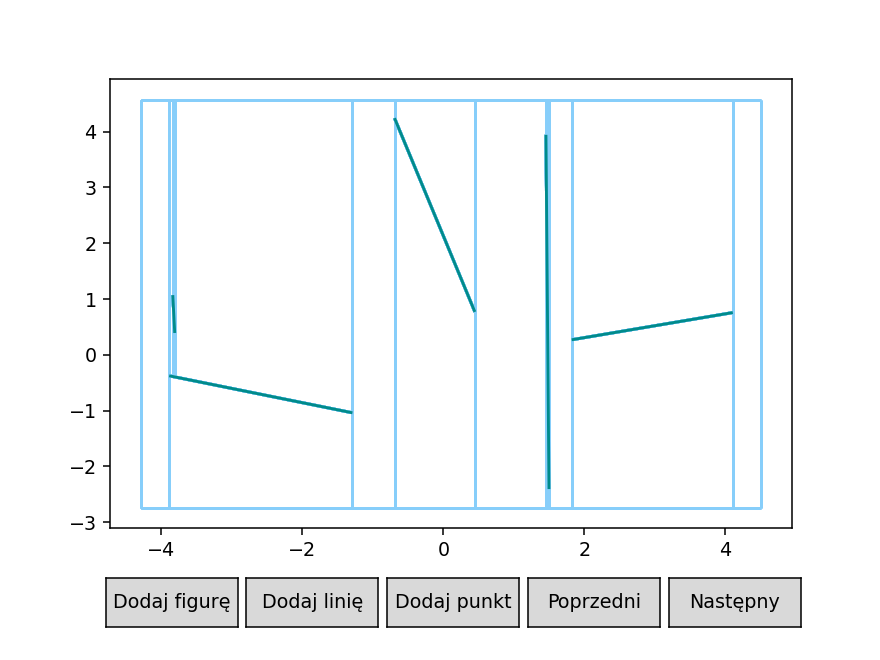

In [38]:
searchGraph, scenes = build_map(l)
plot = Plot(scenes=scenes)
plot.draw()

lewy górny:  (-1.9793257761, -1.565391453)
lewy dolny:  (-1.9793257761, -2.668119487345)
prawy górny:  (0.9129898254, -2.668119487345)
prawy dolny:  (0.9129898254, 0.9481552851036057)


<IPython.core.display.Javascript object>


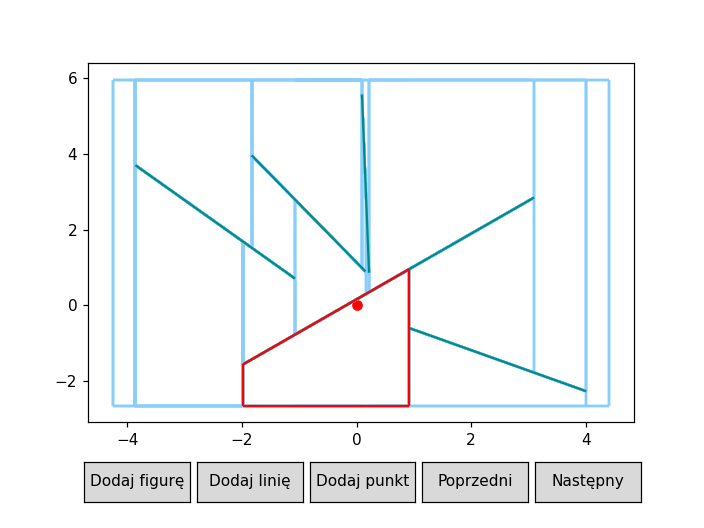

In [221]:
point = Point(0, 0)
find_point(searchGraph, point, scenes[-1])